In [63]:
# ---------------------------------------------------------------------
# 모델링 관련 모듈 로딩
# ---------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchinfo import summary

from torchmetrics.regression import R2Score, MeanSquaredError
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import MulticlassConfusionMatrix
import torch.optim.lr_scheduler as lr_scheduler

import torchvision.models as models

# ---------------------------------------------------------------------
# 데이터 분석 관련 모듈 로딩
# ---------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 이미지 관련 모듈 로딩
# ---------------------------------------------------------------------
import cv2
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from torchvision import datasets

# ---------------------------------------------------------------------
# 기타 모듈 로딩
# ---------------------------------------------------------------------
import time
import os

# 활용 패키지 버전 체크
print(f'torch Ver.:{torch.__version__}')
print(f'pandas Ver.:{pd.__version__}')
print(f'numpy Ver.:{np.__version__}')

torch Ver.:2.4.1
pandas Ver.:2.0.3
numpy Ver.:1.24.3


In [2]:
# DEVICE 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

- 이미지 파일 => 하나로 합치기 <hr>

In [3]:
## 이미지 파일 => 하나로 합치기
## 데이터 관련 설정
IMG_PATH = r'./data_class_4/train_all2/train/'

- Tensor ==> Ndarray <hr>

In [34]:
## 데이터 변형 및 전처리
# transConvert = v2.Compose([
#     v2.Resize([180, 180]),
#     v2.RandomResizedCrop(120),
#     v2.ToTensor(),
#     v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     v2.ToDtype(torch.float32, scale=True)
# ])

transConvert = {
    'Train': v2.Compose([
    v2.Resize([180, 180]),
    v2.RandomResizedCrop(120),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.ToDtype(torch.float32, scale=True)
]),
    'Test': v2.Compose([
    v2.Resize([180, 180]),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.ToDtype(torch.float32, scale=True)
])

}

c:\Users\KDP-43\anaconda3\envs\CV_torch_38\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:
## 이미지 데이터셋 생성
imgDS=ImageFolder(root=IMG_PATH, transform=transConvert['Train'])

In [6]:
print(f'imgDS.classes       : {imgDS.classes}')
print(f'imgDS.class_to_idx  : {imgDS.class_to_idx}')
print(f'imgDS.targets       : {imgDS.targets}')
for img in imgDS.imgs:
    print(f'imgDS.imgs       : {img}')
    break

imgDS.classes       : ['happy', 'hihi', 'shani', 'shuya']
imgDS.class_to_idx  : {'happy': 0, 'hihi': 1, 'shani': 2, 'shuya': 3}
imgDS.targets       : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [26]:
class_names = imgDS.classes

In [7]:
# imgDL=DataLoader(imgDS, batch_size=32)

In [8]:
# train, test 분리

# 모듈 로딩
from torch.utils.data import random_split
trainDS, validDS, testDS = random_split(imgDS, [4000,504,500])

trainDL=DataLoader(trainDS, batch_size=32)
validDL=DataLoader(validDS, batch_size=32)
testDL=DataLoader(testDS, batch_size=32)

In [9]:
# for data, target in imgDL:
#     print(data.shape)
#     print(target.shape)
#     break

In [10]:
### 사전학습된 모델 로딩
model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)

In [11]:
### 모델 구조 확인 
print(model)
# summary(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [12]:
### 사전학습된 모델의 파라미터 비활성화 설정
for named, param in model.named_parameters():
    # print(f'[{named}] - {param.shape}')
    
    # 역전파 시에 업데이트 되지 않도록 설정
    param.requires_grad=False

In [13]:
model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 4)
)

In [25]:
print(model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=4, bias=True)
  )
)


In [15]:
### classifier 파라미터 활성화 설정
for named, param in model.classifier[6].named_parameters():
    print(f'[{named}] - {param.shape}')
    param.requires_grad=True

[0.weight] - torch.Size([512, 4096])
[0.bias] - torch.Size([512])
[3.weight] - torch.Size([4, 512])
[3.bias] - torch.Size([4])


In [16]:
model=model.to(DEVICE)

In [17]:
# print(model)

In [18]:
# 최적화 인스턴스
optimizer = torch.optim.Adam(model.classifier[6].parameters(), lr=0.01)

# 손실함수 인스턴스
loss_func = torch.nn.CrossEntropyLoss()

# 최적화 스케쥴링 인스턴스 생성 => lr 조절 및 성능 개선 여부 체크
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True) # score 사용 시


c:\Users\KDP-43\anaconda3\envs\CV_torch_38\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [19]:
def train_model(model, loss_func, optimizer, num_epochs=1, is_train=True):
    since = time.time()
    loss_history = [],[]
    acc_history = [],[]
    best_acc = 0.0
    # num_epochs = 5

    for epoch in range(num_epochs):
        # 학습 모드로 모델 설정
        model.train()

        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        running_corrects = 0
        running_loss = 0.0
        
        score_total = 0

        for featureTS, targetTS in trainDL:

            # DEVICE : CPU/GPU 사용
            featureTS=featureTS.to(DEVICE)
            targetTS=targetTS.to(DEVICE)
            
            # 학습 진행
            pre_y = model(featureTS)

            # 손실 계산
            loss = loss_func(pre_y, targetTS)

            # # 예제 점수계산법
            _, preds = torch.max(pre_y, 1)

            # 성능평가 계산
            score=MulticlassF1Score(num_classes=4)(pre_y, targetTS.reshape(-1))
            score_total += score.item()

            # 최적화 진행
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_corrects += torch.sum(preds == targetTS.data)
            running_loss += loss.item() * featureTS.size(0) # loss값 * batch_size

        # 검증 모드로 모델 설정
        model.eval()

        running_val_corrects = 0
        running_val_loss = 0.0
        
        with torch.no_grad():
            # 검증 데이터셋
            for feature, target in validDL:
                
                # CPU/GPU 사용
                feature=feature.to(DEVICE)
                target=target.to(DEVICE)

                # 평가
                pre_val=model(feature)

                # 손실
                loss_val=loss_func(pre_val, target.reshape(-1).long())

                # 성능평가
                score_val=MulticlassF1Score(num_classes=4)(pre_val, target.reshape(-1))
            
            running_val_corrects+=score_val.item()
            running_val_loss+=loss_val.item()

        epoch_acc = running_corrects.double() / len(trainDL)
        epoch_loss = running_loss / len(trainDL)

        print('[TRAIN] LOSS: {:.4f} SCORE: {:.4f}'.format(epoch_loss, score_total/len(trainDL))) 
        print('[VAL] LOSS: {:.4f} SCORE: {:.4f}'.format(running_val_loss, running_val_corrects))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        loss_history[0].append(epoch_loss)        
        acc_history[0].append(score_total)

        loss_history[1].append(running_val_loss)
        acc_history[1].append(running_val_corrects)

        ### 모델 저장 부분
        # 끝나는 시간 저장
        end_time = time.strftime('%y.%m.%d..%H_%M_%S')

        # 모델 파라미터 저장
        if len(acc_history[1]) == 1:
            torch.save(model.state_dict(), os.path.join('./models/', '{0:0=2d}_{1}.pth'.format(epoch+1, end_time)))
        else:
            if acc_history[1][-1] > max(acc_history[1][:-1]):
                torch.save(model.state_dict(), os.path.join('./models/', '{0:0=2d}_{1}.pth'.format(epoch+1, end_time)))
        print()

        # 모델 경로 지정
        SAVE_PATH = './models'
        SAVE_MODEL = f'/model_num_loss({epoch_loss:.4f})_score({score_total/len(trainDL):.4f}).pth'
        
        # 모델 전체 저장
        if len(acc_history[1]) == 1:
            torch.save(model, SAVE_PATH+SAVE_MODEL)
        else:
            if acc_history[1][-1] > max(acc_history[1][:-1]):
                torch.save(model, SAVE_PATH+SAVE_MODEL)

        # 최적화 스케쥴러 인스턴스 업데이트
        scheduler.step(loss_val)
        print(f'scheduler.num_bad_epochs => {scheduler.num_bad_epochs}', end=' ')
        print(f'scheduler.patience => {scheduler.patience}')

        # 손실 감소(또는 성능 개선)이 안되는 경우 조기종료
        if scheduler.num_bad_epochs >= scheduler.patience:
            print(f'{scheduler.patience}EPOCH 성능 개선이 없어서 조기종료함')
            break

    time_elapsed = time.time() - since
    print('모델 학습 시간: {:.0f}분 {:.0f}초'.format(time_elapsed // 60, time_elapsed % 60))

In [20]:
train_model(model, loss_func, optimizer, num_epochs=1, is_train=True)

Epoch 1/1
----------
[TRAIN] LOSS: 39.1419 SCORE: 0.5849
[VAL] LOSS: 0.6416 SCORE: 0.7292

scheduler.num_bad_epochs => 0 scheduler.patience => 5
모델 학습 시간: 5분 1초


#### 테스트

In [24]:
model.eval()

running_val_corrects = 0
running_val_loss = 0.0

with torch.no_grad():
	# 검증 데이터셋
	for feature, target in testDL:
		
		# CPU/GPU 사용
		feature=feature.to(DEVICE)
		target=target.to(DEVICE)

		# 평가
		pre_val=model(feature)

		# 모델 출력에 소프트맥스 적용하여 확률 분포로 변환
		pre_val_probs = F.softmax(pre_val, dim=1)

		_, preds = torch.max(pre_val, 1)

		# 손실
		loss_val=loss_func(pre_val, target.reshape(-1).long())

		# 성능평가
		score_val=MulticlassF1Score(num_classes=4)(pre_val_probs, target.reshape(-1))

running_val_corrects+=score_val.item()
running_val_loss+=loss_val.item()

print("="*30,"DATA","="*30)
print(pre_val)
print(preds)
print(target)
print("="*75)
print('[VAL] LOSS: {:.4f} SCORE: {:.4f}'.format(running_val_loss, running_val_corrects))
		



============================== DATA ==============================
tensor([[-1.0187e+00, -1.4205e+00,  2.7186e-02,  1.8111e+00],
        [-2.3301e-01,  3.0502e-02, -7.6037e-02,  7.2059e-01],
        [-4.7012e-01, -2.0595e+00,  1.8710e+00,  2.2707e-01],
        [-9.1915e-01, -3.8404e+00,  3.6816e+00,  1.4570e-01],
        [ 1.4600e+00, -1.0028e+00,  5.8573e-02, -4.3340e-01],
        [-1.9683e-01, -3.3569e-01,  2.9103e-03,  2.2215e-01],
        [-3.3116e-01, -2.2851e+00,  2.4218e+00, -4.9342e-02],
        [-1.4654e+00, -3.8115e+00,  4.2934e+00,  4.7146e-01],
        [-3.5167e-01,  1.3032e+00, -9.4681e-01, -4.4530e-01],
        [-5.9710e-01, -2.8498e+00,  2.8212e+00,  2.2339e-01],
        [-3.3636e-01, -8.6950e-02,  1.2894e-01, -3.2356e-02],
        [-1.1241e-01, -5.3319e-01,  8.5670e-02,  4.9329e-02],
        [-9.4735e-02,  4.7667e-01, -3.2651e-01, -3.0882e-03],
        [ 3.6700e-01,  9.4367e-01, -8.0881e-01,  3.7929e-01],
        [ 2.0191e+00, -1.4770e+00,  1.1367e+00, -1.2925e+00],
   

In [49]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = transConvert['Test'](img)
    img = img.unsqueeze(0)
    img = img.to(DEVICE)
    
    img_clip = np.clip(img,0,1)
    # print(img_clip)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        plt.imshow(img_clip.cpu().data[0].permute(1,2,0))

        model.train(mode=was_training)

##### np.clip
- RGB 이미지 데이터를 시각화할 때 데이터가 특정 범위 내에 있어야
- 정수형 데이터: 픽셀 값이 [0, 255] 범위에 있어야
- 부동소수점(float) 데이터: 픽셀 값이 [0, 1] 범위에 있어야

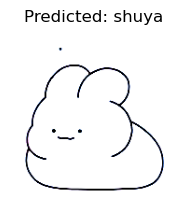

In [50]:
visualize_model_predictions(
    model,
    img_path=r"data_class_4/train_all2/test/shuya/u152.jpg"
)

plt.ioff()
plt.show()

In [52]:
# 모델 로드 & 예측----------------------------------------------------

## 저장경로
SAVE_PATH= r'C:\Users\KDP-43\Desktop\project_OpenCV\models'

# 저장 파일명
SAVE_MODEL = SAVE_PATH+'\model_num_loss(28.3553)_score(80.1115)'

if os.path.exists(SAVE_MODEL):
	emoticon_rabbit= torch.load(SAVE_MODEL, weights_only=False)
	print("경로상 파일이 존재합니다.")
else:
	print(f'{SAVE_MODEL} 파일이 존재하지 않습니다. 다시 확인하세요.')

경로상 파일이 존재합니다.


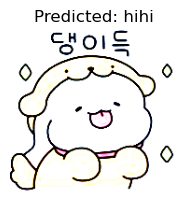

In [60]:
img_path = r"C:\Users\KDP-43\Desktop\project_OpenCV\data_class_4\train_all2\test\shani\u999.jpg"

model.eval()

img = Image.open(img_path)
img = transConvert['Test'](img)
img = img.unsqueeze(0)
img = img.to(DEVICE)

img_clip = np.clip(img,0,1)

with torch.no_grad():
	outputs = model(img)
	_, preds = torch.max(outputs, 1)

ax = plt.subplot(2,2,1)
ax.axis('off')
ax.set_title(f'Predicted: {class_names[preds[0]]}')
plt.imshow(img_clip.cpu().data[0].permute(1,2,0))

plt.ioff()
plt.show()

#### 여러개 이미지 그리기 & 예측 라벨 그림 그리기

In [73]:
test_path = r"C:\Users\KDP-43\Desktop\project_OpenCV\data_class_4\train_all2\test"

test_dataset = ImageFolder(test_path, transform=transConvert['Test'])

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 12,
    num_workers=2,
    shuffle=True
)

print(len(test_dataset))

samples, labels = iter(test_loader).__next__()
classes = dict(zip(range(len(test_dataset.classes)), test_dataset.classes))
print(classes)

print(labels)

fig = plt.figure(figsize=(12,18))

# img_clip = np.clip(img,0,1)

for i in range(12):
    a = fig.add_subplot(4,3, i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    tmp = np.transpose(samples[i].numpy(), (1,2,0))
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
    
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

203


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

{0: 'happy', 1: 'hihi', 2: 'shani', 3: 'shuya'}
tensor([1, 3, 2, 3, 0, 3, 2, 2, 2, 2, 1, 2])


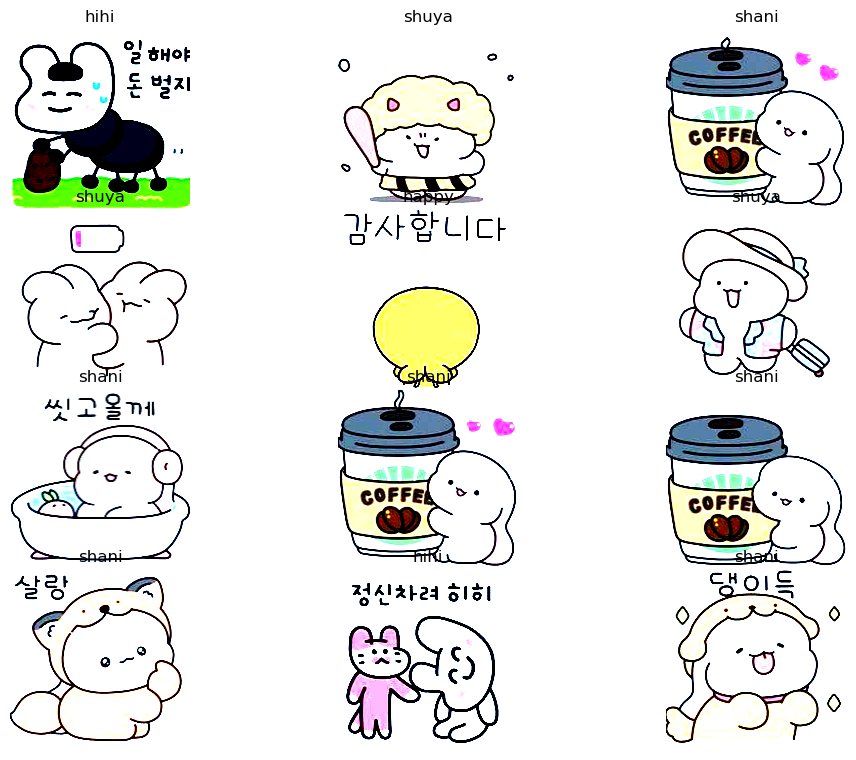

In [74]:
plt.ioff()
plt.show()

In [ ]:
# test_path = r"C:\Users\KDP-43\Desktop\project_OpenCV\data_class_4\train_all2\test"

test_dataset = ImageFolder(test_path, transform=transConvert['Test'])

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 12,
    num_workers=2,
    shuffle=True
)

print(len(test_dataset))

samples, labels = iter(test_loader).__next__()
classes = dict(zip(range(len(test_dataset.classes)), test_dataset.classes))
print(classes)

print(labels)

fig = plt.figure(figsize=(12,18))

# img_clip = np.clip(img,0,1)

for i in range(12):
    a = fig.add_subplot(4,3, i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    tmp = np.transpose(samples[i].numpy(), (1,2,0))
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
    
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)